In [ ]:
import pandas as pd

sample1 = pd.read_csv('data/output.csv', names=["book1"])  #index_col=0 하면 안됨
sample1.sample(n=8)

,book1
246,“……”
2,이날이야말로 동소문 안에서 인력거꾼 노릇을 하는 김첨지에게는 오래간만에도 닥친 운...
216,"“안 죽었어, 안 죽었대도 그래.”"
66,그 학생을 태우고 나선 김첨지의 다리는 이상하게 거뿐하였다.
32,라고 물었다.
178,벽에 맞아 떨어진 돈은 다시 술 끓이는 양푼에 떨어지며 정당한 매를 맞는다는 듯이...
132,그럴 즈음에 마침 길가 선술집에서 그의 친구 치삼이가 나온다.
142,하고 김첨지는 얼굴을 펴서 웃었다.


In [ ]:
sample1.columns

Index(['book1'], dtype='object')

In [1]:
# 라이브러리 불러오기
import torch
from torch import nn
from torch.utils.data import Dataset
import gluonnlp as nlp
import numpy as np
 
#kobert
from kobert_tokenizer import KoBERTTokenizer

# transformers
from transformers import BertModel

# GPU 사용시 필요
device = torch.device("cuda:0")

In [2]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = tokenizer.tokenize

In [3]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6, #클래스 수 조정
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [4]:
model = torch.load('model/kobert-v6.pt')

max_len = 64
batch_size = 64

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         
    def __len__(self):
        return (len(self.labels))

In [5]:
def predict(sentence):
    dataset = [[sentence, '0']]
    test = BERTDataset(dataset, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=0)
    model.eval()
    answer = 0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        for logits in out:
            logits = logits.detach().cpu().numpy()
            answer = np.argmax(logits)
    return answer

In [6]:
emos = ('행복','불안','놀람', '슬픔','분노','중립')
def sa_demo(sentence):
    res = predict(sentence)
    print("문장에서 "+ emos[res] + "이(가) 느껴집니다.")

In [ ]:
emos = ('행복','불안','놀람', '슬픔','분노','중립')
res = {'행복':0,'불안':0,'놀람':0, '슬픔':0,'분노':0,'중립':0}

for index, data in sample1.iterrows():
    res[emos[predict(data['book1'])]] += 1
res

{'행복': 32, '불안': 10, '놀람': 20, '슬픔': 24, '분노': 46, '중립': 124}

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print(font_list)

['C:\\Windows\\Fonts\\simsunb.ttf', 'C:\\Windows\\Fonts\\segoescb.ttf', 'C:\\Windows\\Fonts\\segoeui.ttf', 'C:\\Users\\KangIW\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicLight.ttf', 'C:\\Windows\\Fonts\\MATURASC.TTF', 'C:\\Windows\\Fonts\\SitkaZ.ttc', 'C:\\Windows\\Fonts\\pala.ttf', 'C:\\Windows\\Fonts\\GILI____.TTF', 'C:\\Windows\\Fonts\\FRABKIT.TTF', 'C:\\Windows\\Fonts\\BOOKOSB.TTF', 'C:\\Windows\\Fonts\\BOD_R.TTF', 'C:\\Windows\\Fonts\\BKANT.TTF', 'C:\\Windows\\Fonts\\ARIALNB.TTF', 'C:\\Windows\\Fonts\\arialbd.ttf', 'C:\\Windows\\Fonts\\georgiaz.ttf', 'C:\\Windows\\Fonts\\ROCKBI.TTF', 'C:\\Windows\\Fonts\\SCHLBKB.TTF', 'C:\\Windows\\Fonts\\cambriaz.ttf', 'C:\\Windows\\Fonts\\calibri.ttf', 'C:\\Windows\\Fonts\\GIGI.TTF', 'C:\\Windows\\Fonts\\COOPBL.TTF', 'C:\\Windows\\Fonts\\seguili.ttf', 'C:\\Windows\\Fonts\\BOD_CI.TTF', 'C:\\Windows\\Fonts\\malgun.ttf', 'C:\\Windows\\Fonts\\comicbd.ttf', 'C:\\Windows\\Fonts\\DUBAI-BOLD.TTF', 'C:\\Windows\\Fonts\\framd.ttf', 'C:\\Windows

In [ ]:
fontpath = r'C:\Windows\Fonts\HMKMRHD.TTF'
font_name = fm.FontProperties(fname=fontpath, size=50).get_name()
plt.rc('font', family=font_name)
print(plt.rcParams['font.family']) #적용됬는지 확인

['Headline R']


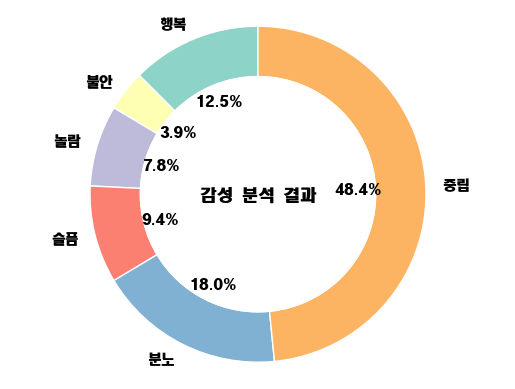

In [ ]:
import matplotlib.pyplot as plt

# 키와 값 리스트 추출
labels = list(res.keys())
sizes = list(res.values())

# 원형 그래프 그리기
fig1, ax1 = plt.subplots()

# 가운데 부분을 뚤린 원형으로 설정
wedgeprops = {'width': 0.3, 'edgecolor': 'white'}  # 가운데 부분 속성

# 원형 그래프 그리기
outer_colors = plt.cm.Set3(range(len(labels)))  # 바깥 부분 색상
inner_colors = ['white'] * len(labels)  # 가운데 부분 색상

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=outer_colors, wedgeprops=wedgeprops)

ax1.pie([1], radius=0.7, colors=inner_colors, wedgeprops=wedgeprops)  # 가운데 뚤린 원형 추가

# 가운데 부분에 텍스트 추가
plt.text(0, 0, '감성 분석 결과', ha='center', va='center', fontsize=12)

# 가운데 뚤린 원형 그래프 출력
plt.axis('equal')
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Github/floread
!git checkout feature_sentiment-analysis

/content/drive/MyDrive/Github/floread
M	sentiment-analysis/train koelectra-v2.ipynb
M	sentiment-analysis/visualize.ipynb
Already on 'feature_sentiment-analysis'
Your branch is up to date with 'origin/feature_sentiment-analysis'.


In [7]:
import pandas as pd

sample1 = pd.read_csv('sentiment-analysis/data/output.csv', names=["book1"])  #index_col=0 하면 안됨
sample1.sample(n=8)

,book1
252,하는 말 끝엔 목이 메였다.
84,다리를 재게 놀려야만 쉴새없이 자기의 머리에 떠오르는 모든 근심과 걱정을 잊을 듯이.
83,집이 차차 멀어 갈수록 김첨지의 걸음에는 다시금 신이 나기 시작하였다.
0,운수 좋은날
248,“……”
2,이날이야말로 동소문 안에서 인력거꾼 노릇을 하는 김첨지에게는 오래간만에도 닥친 운...
90,"노동으로 하여 흐른 땀이 식어지자 굶주린 창자에서, 물 흐르는 옷에서 어슬어슬 한..."
63,하고 빙글빙글 웃는 차부의 얼굴에는 숨길 수 없는 기쁨이 넘쳐흘렀다.


In [12]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.3 MB/s eta 0:00:00


In [15]:
import torch
from transformers import AutoTokenizer
device = torch.device("cuda:0")

In [13]:
%cd /content/drive/MyDrive/Github/floread/sentiment-analysis
model2 = torch.load('model/koelectra-v2.pt')
model2

/content/drive/MyDrive/Github/floread/sentiment-analysis


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [ ]:
class mscDataset(Dataset):  #multi-label sentiment classification
  def __init__(self, csv_file):
    # 결측치 제거
    self.dataset = csv_file
    # 중복값 제거
    self.dataset.drop_duplicates(subset=['sentence'], inplace=True)
    self.tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

    print(self.dataset.describe())

#   def __init__(self, csv_file):
#     self.tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v2-discriminator")
#     print(self.dataset.describe())

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 0:2].values
    text = row[0]
    y = row[1]

    inputs = self.tokenizer(
        text, 
        return_tensors='pt',
        truncation=True,
        max_length=256,
        pad_to_max_length=True,
        add_special_tokens=True
        )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return input_ids, attention_mask, y

In [ ]:
emos = ('행복','불안','놀람', '슬픔','분노','중립')
res = {'행복':0,'불안':0,'놀람':0, '슬픔':0,'분노':0,'중립':0}